<p align="center">
Universidade Federal de Alagoas</br>

Instituto de Computação</br>

</p>

#Trabalho Prático AB2

Disciplina: Sistemas Distribuídos

Semestre letivo: 2017.1

Professor: André Lage Freitas

## Especificação

**Importante**. Leia atentamente essa seção pois só serão aceitos trabalhos que obedecerem as a especificações a seguir. 

Baseado(a) no exemplo a seguir de implementação do B-multicast em Julia, façam os exercícios descritos nesse documento.

# B_multicast

In [1]:
using Distributed
using Plots
using StatsPlots

function mean(array)
    return(sum(array) / length(array))
end

function std(array)
    s, m = 0, mean(array)
    for x in array
        s += (x - m)*(x - m)
    end
    return(sqrt(s / (length(array) - 1)))
end

std (generic function with 1 method)

In [2]:
z, iterations = 1.96, 50
addprocs(10)
group = workers()

10-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [3]:
@everywhere function B_deliver(message)
#     println(message)
#     flush(stdout)
    sleep(0.01)
end

function B_sync_multicast(group, message, B_deliver)
    for i in group
        @sync @spawnat i B_deliver(message)
    end
end

function B_async_multicast(group, message, B_deliver)
    @sync for i in group
        @spawnat i B_deliver(message)
    end
end

B_async_multicast (generic function with 1 method)

In [4]:
syncTimes = []
for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(syncTimes, @elapsed B_sync_multicast(group, "Sync hi  -- $i", B_deliver))
end

1 -----------------------------------
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 -------------------------------

In [5]:
asyncTimes = []
asyncTotalTime = for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(asyncTimes, @elapsed B_async_multicast(group, "Async hi -- $i", B_deliver))
end

1 -----------------------------------
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 -------------------------------

Sync total time: 11.642611702 || Async total time: 0.5558639049999999
Sync mean time: 0.29106529255 || Async mean time: 0.013896597624999998
Sync std time: 1.0673509961034613 || Async std time: 0.0025519934363139474
Sync: [0.110585, 0.110607, 0.110614, 0.110628, 0.11064, 0.110652, 0.111533, 0.111555, 0.111606, 0.111691, 0.112574, 0.114613, 0.116715, 0.117511, 0.118618, 0.119457, 0.119593, 0.119631, 0.119637, 0.119646, 0.120509, 0.120541, 0.120559, 0.120654, 0.120666, 0.1215, 0.121553, 0.121693, 0.121807, 0.12254, 0.122575, 0.122618, 0.125393, 0.127669, 0.128457, 0.133592, 0.147495, 0.180682, 0.181874, 6.87213]
Async: [0.0130441, 0.0130442, 0.0130553, 0.0130691, 0.0131147, 0.0131435, 0.0131627, 0.0131668, 0.0131693, 0.0132059, 0.013214, 0.0132339, 0.0132593, 0.0132955, 0.0133094, 0.013315, 0.0133419, 0.0133641, 0.013377, 0.0133953, 0.0135142, 0.0135301, 0.0135579, 0.0135588, 0.0135688, 0.0135692, 0.0135763, 0.0136193, 0.0136327, 0.0136837, 0.0138144, 0.0138317, 0.013866, 0.0139055, 0.01

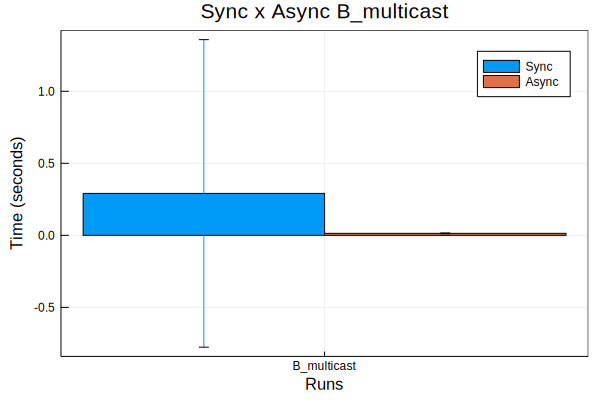

In [6]:
syncTimes, asyncTimes = Array{Float64}(syncTimes), Array{Float64}(asyncTimes)
sort!(syncTimes), sort!(asyncTimes)
deleteat!(syncTimes, UnitRange(length(syncTimes) - 10, length(syncTimes)))
deleteat!(asyncTimes, UnitRange(length(asyncTimes) - 10, length(asyncTimes)))
syncTotalTime, asyncTotalTime = sum(syncTimes), sum(asyncTimes)
syncMeanTime, asyncMeanTime = mean(syncTimes), mean(asyncTimes)
syncStdTime, asyncStdTime = std(syncTimes), std(asyncTimes)

println("Sync total time: $syncTotalTime || Async total time: $asyncTotalTime")
println("Sync mean time: $syncMeanTime || Async mean time: $asyncMeanTime")
println("Sync std time: $syncStdTime || Async std time: $asyncStdTime")
println("Sync: $syncTimes")
println("Async: $asyncTimes")

# plot(1:length(syncTimes),
#          [syncTimes, asyncTimes],
#          title="Sync x Async B_multicast",
#          label=["Sync", "Async"],
#          xlabel="Runs",
#          ylabel="Time (s)")
groupedbar(
           ["B_multicast"],
           [syncMeanTime asyncMeanTime],
           yerr = [syncStdTime asyncStdTime],
           label = ["Sync", "Async"],
           xlabel = "Runs",
           ylabel = "Time (seconds)",
           title = "Sync x Async B_multicast",
           framestyle = :box)

# --------------------------------------------------------------------------------------------------------------
# R_multicast

In [7]:
z, iterations = 1.96, 50
rmprocs(workers())
addprocs(10)
group = workers()

10-element Array{Int64,1}:
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21

In [8]:
counter = 0

@everywhere function B_sync_deliver(group, from, message)
    global received
#     println(message)
#     flush(stdout)
#     sleep(0.01)
    
    if !(from in received)
        push!(received, from)
        if from != myid()
            B_sync_multicast(group, message, B_sync_deliver)
        end
        sleep(0.01)
    end
    @spawnat 1 global counter += 1
end

@everywhere function B_sync_multicast(group, message, B_deliver)
    my_id = myid()
    for i in group
        @sync @spawnat i B_sync_deliver(group, my_id, message)
    end
end

function R_sync_multicast(group, message)
    @everywhere group global received = Set()

    for i in group
        @sync @spawnat i B_sync_multicast(group, message, B_sync_deliver)
    end
end
    
@everywhere function B_async_deliver(group, from, message)
    global received
#     println(message)
#     flush(stdout)
#     sleep(0.01)
    
    if !(from in received)
        push!(received, from)
        if (from != myid())
            B_async_multicast(group, message, B_async_deliver)
        end
        sleep(0.01)
    end
end

@everywhere function B_async_multicast(group, message, B_deliver)
    my_id = myid()
    @sync for i in group
        @spawnat i B_async_deliver(my_id, message)
    end
end

function R_async_multicast(group, message)
    @everywhere group global received = Set()

    @sync for i in group
        @spawnat i B_sync_multicast(group, message, B_sync_deliver)
    end
end

R_async_multicast (generic function with 1 method)

In [9]:
syncTimes = []
for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(syncTimes, @elapsed R_sync_multicast(group, "Sync hi  -- $i"))
    if i == 1
        println(counter)
    end
end

1 -----------------------------------
1000
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 --------------------------

In [10]:
asyncTimes = []
asyncTotalTime = for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(asyncTimes, @elapsed R_async_multicast(group, "Async hi -- $i"))
end

1 -----------------------------------
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 -------------------------------

Sync total time: 57.441269899000005 || Async total time: 9.326346499000001
Sync mean time: 1.4728530743333335 || Async mean time: 0.23913708971794875
Sync std time: 0.03510493812201742 || Async std time: 0.010284906390932765
Sync: [1.39343, 1.40596, 1.42392, 1.426, 1.4294, 1.43171, 1.43241, 1.43511, 1.43569, 1.43599, 1.44093, 1.44293, 1.46265, 1.46374, 1.46727, 1.46869, 1.47191, 1.47297, 1.47559, 1.47703, 1.47892, 1.4891, 1.49043, 1.49186, 1.49217, 1.49283, 1.49823, 1.49969, 1.50117, 1.50158, 1.50299, 1.50375, 1.50477, 1.50498, 1.50583, 1.51221, 1.51529, 1.52714, 1.53504]
Async: [0.214642, 0.223397, 0.224515, 0.225267, 0.225446, 0.225476, 0.2261, 0.22674, 0.226993, 0.231434, 0.232034, 0.233289, 0.233877, 0.236938, 0.238758, 0.238793, 0.239115, 0.239214, 0.240644, 0.240971, 0.242244, 0.242329, 0.242843, 0.243088, 0.243846, 0.24443, 0.244701, 0.245141, 0.245474, 0.245644, 0.246404, 0.24709, 0.248986, 0.248993, 0.250663, 0.253443, 0.254472, 0.254668, 0.258246]


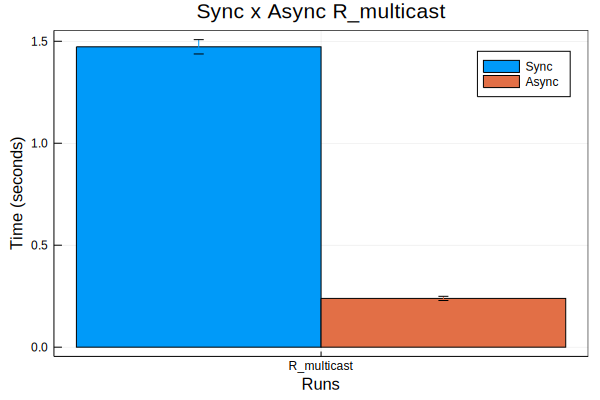

In [11]:
syncTimes, asyncTimes = Array{Float64}(syncTimes), Array{Float64}(asyncTimes)
sort!(syncTimes), sort!(asyncTimes)
deleteat!(syncTimes, UnitRange(length(syncTimes) - 10, length(syncTimes)))
deleteat!(asyncTimes, UnitRange(length(asyncTimes) - 10, length(asyncTimes)))
syncTotalTime, asyncTotalTime = sum(syncTimes), sum(asyncTimes)
syncMeanTime, asyncMeanTime = mean(syncTimes), mean(asyncTimes)
syncStdTime, asyncStdTime = std(syncTimes), std(asyncTimes)

println("Sync total time: $syncTotalTime || Async total time: $asyncTotalTime")
println("Sync mean time: $syncMeanTime || Async mean time: $asyncMeanTime")
println("Sync std time: $syncStdTime || Async std time: $asyncStdTime")
println("Sync: $syncTimes")
println("Async: $asyncTimes")

# plot(1:length(syncTimes),
#          [syncTimes, asyncTimes],
#          title="Sync x Async B_multicast",
#          label=["Sync", "Async"],
#          xlabel="Runs",
#          ylabel="Time (s)")
groupedbar(
           ["R_multicast"],
           [syncMeanTime asyncMeanTime],
           yerr = [syncStdTime asyncStdTime],
           label = ["Sync", "Async"],
           xlabel = "Runs",
           ylabel = "Time (seconds)",
           title = "Sync x Async R_multicast",
           framestyle = :box)

In [12]:
# function B_multicast(g,m,B_deliver)
#    for p in g
#        remotecall(p, B_deliver, m)
#    end
# end

# Adding 3 processes (workers)
#addprocs(3)

# My group is composed by all workers
# g = workers()

# Multicasting "oi!" message to group `g` by assuming `println` as B_deliver function.
# B_multicast(g,"oi!",println)

### Exercício 1: Sincronismo (2,0 pontos)

Adicione 10 processos com o comando `addprocs` abaixo. 

_Atenção_: sua instalação local de Julia pode não conseguir adicionar 10 processos, use a [JuliaBox](https://juliabox.com).

In [13]:
# addprocs(10)

Modifique a implementação do B-multicast para utilizar communicação síncrona.

In [14]:
#TODO implementação do B-multicast síncrono.

Execute as duas versões do B-multicast (síncrona e assíncrona) e compare as saídas.

A ordem das mensagens das saídas foram as mesmas para ambas versões do B-multicast? Por quê?

**Resposta**: _em itálico_



### Exercício 2: Análise de desempenho do B-multicast (2,0 pontos)

Meça o tempo de execução duas versões do B-multicast (síncrona e assíncrona). Dica: utilize a macro `@time`.

* Execute 50 vezes essa medição e construa um gráfico em forma de barras:
	* cada barra representando cada versão do B-multicast;
	* calcule e coloque no gráfico o [intervalo de confiança](https://en.wikipedia.org/wiki/Confidence_interval) com nível de 95%.
    
**Gráfico**: _por aqui_    
    
    
* Qual das duas versões teve o menor tempo de execução? Por quê?

**Resposta**: _em itálico_



### Exercício 3: Análise de desempenho do R-multicast (3,0 pontos)

Implemente duas versões do algoritmo R-multicast: uma assíncrona e outra síncrona.

* R-multicast assíncrono

In [15]:
#TODO implementação do R-multicast síncrono.

* R-multicast assíncrono

In [16]:
#TODO implementação do R-multicast assíncrono.

Faça a mesma análise de desempenho para o R-multicast que você fez no Exercício 2.


**Gráfico**: _por aqui_    
    
    
* Qual das duas versões (R-multicast assíncrono e assíncrono) teve o menor tempo de execução? Por quê?

**Resposta**: _em itálico_



### Exercício 4: Análise de desempenho: B-multicast vs. R-multicast (3,0 pontos)

Para cada uma das comparações abaixo, qual dos algoritmos teve o menor tempo de execução? Por quê?

* B-multicast assíncrono vs. R-multicast assíncrono.
    

**Resposta**: _em itálico_    
    
* B-multicast síncrono vs. R-multicast síncrono.


**Resposta**: _em itálico_

## Entrega

As respostas deverão ser entregues nos devidos campos desse arquivo, ou seja, em [Markdown](https://en.wikipedia.org/wiki/Markdown) e no formato [IJulia Notebook](https://github.com/JuliaLang/IJulia.jl).

O programa deve ser implementado na linguagem de programação **Julia**. Seu trabalho será testado na [JuliaBox](https://juliabox.com), portanto teste seu arquivo IJulia na JulizBox antes de enviá-lo.


### Forma 

O arquivo IJulia Notebook deverá ser entregue ao Professor **exclusivamente através do Google Classroom**.



A responsabilidade sobre a integridade do arquivo contendo trabalho é exclusivamente dos discentes. Serão ignorados os trabalhos cujos arquivos não conseguirem ser abertos pelo Professor.

### Prazos

O prazo de entrega sem atraso é o dia **18/11/17**.

Trabalhos entregues com atraso serão aceitos, no máximo, até o o dia **19/11/17**. Serão descontados 5% da nota obtida por dia de atraso.


## Pontuação extra

O(a) discente que realizar mais tarefas, além do que foi especificado neste trabalho, o professor atribuirá de 0,5 a 1,0 ponto extra a depender da relevância da contribuição no programa. O critério será decidido pelo professor. 

O(a) discente deve indicar qual é a tarefa executada. Por exemplo, adição de funcionalidades, armazenamento de dados em arquivo, documentação de código, comentários em inglês sem erros ortográficos, etc.


**Plágio** A nota zero será atribuída caso haja qualquer tipo de cópia parcial ou integral assim como as devidas medidas legais. Leia a [cartilha sobre plágio](http://www.noticias.uff.br/arquivos/cartilha-sobre-plagio-academico.pdf).

## Disclaimer

Esse material foi elaborado pelo [Prof. André Lage Freitas](https://sites.google.com/a/ic.ufal.br/andrelage/) e está licenciado sob a licença _GNU General Public License v3.0_.